---
**License**

 LRTvsFisher

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 LRTvsFisher\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

# Likelihood ratio test vs. Fisher matrix

Example to compare the results from Likelihood ratio test (profile likelihood) and Fisher matrix methods. 
For this, we obtain constraints (68.27% contour) on the cold dark matter density $\Omega_c$ and the dark energy equation 
of state $w$ parameters, where $w =$ constant, using type Ia supernova (SNeIa) and baryon acoustic oscillations (BAO) data.

## Loading NumCosmo

The first step is to load both NumCosmo and NumCosmoMath libraries. We also load some Python packages.

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

import sys
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### Initializing the NumCosmo library:

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

### Initializing the objects

We first initialize the **NcHICosmo** object. It describes a cosmological model assuming a homogeneous and isotropic metric of the background. 

In particular, we initialize a **NcHICosmo** child whose Dark Energy (DE) component is described by a barotropic fluid with constant equation of state, **NcHICosmoDEXcdm**.

One choice we make here is to parametrize the problem considering the curvature density parameter, $\Omega_k$, instead of the DE density parameter $\Omega_{DE}$. 
We then set the values for the others cosmological parameters: 
1. The Hubble constant $H_0$;
2. The DE equation of state parameter $w$;
3. The baryon density parameter $\Omega_b$;
4. The cold dark matter density parameter $\Omega_c$;
5. The mass(es) of the neutrino(s) $m_{\nu}$;
6. The effective number of massless neutrinos $N_{\nu}$;
7. The temperature of the photons today $T_{\gamma 0}$.

The parameters that are not set here kepp the default values.

In [3]:
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<1>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        67.66)
cosmo.param_set_by_name ("Omegak",    0.0)
cosmo.param_set_by_name ("w",         -0.8)
cosmo.param_set_by_name ("Omegab",    0.049)
cosmo.param_set_by_name ("Omegac",    0.2621)
cosmo.param_set_by_name ("massnu_0",  0.0)
cosmo.param_set_by_name ("ENnu",      3.046)
cosmo.param_set_by_name ("Tgamma0",   2.7255)


###  Model Set

We initialize a model set (NcmSet) object, and set the cosmological model (cosmo) into mset. 

In [4]:
mset = Ncm.MSet ()
mset.set (cosmo)

Setting $\Omega_c$ and $w$ parameters to be fitted.

In [5]:
cosmo.props.Omegac_fit = True
cosmo.props.Omegax_fit = True
cosmo.props.w_fit = True


### Initializing the distance object

At this step we initialize the NcDistance object. This object computes the cosmological distances using an interpolation method (spline) as a matter of optimization. 

The argument of the *new* function corresponds to the maximum redshift $z_{max}$ up to which the spline of the comoving distance will be prepared. The cosmological distances depend on the cosmological model. 

**Note that** if the user calls a distance function at a redshift $z^\prime$ bigger than $z_{max}$, then the computation between $z_{max}$ and $z^\prime$ is performed by numerical integration.

In [6]:
zmax = 2.5
dist = Nc.Distance.new (zmax)

### Initializing data objects

1. A new Data object NcmData from Type Ia supernovae (snia) catalogs. Distance modulus $\mu(z)$:
$$\mu(z) = 5\log_{10}[c/H_0 * D_l(z)/(1\,\text{Mpc})] + 25,$$
where $c$ is the speed of light and $D_l(z) = (1 + z) D_M(z)$ is the luminosity distance.

2. New data objects from baryon acoustic oscillations (BAO).
$$D_V(z) \equiv \left[ z D_M(z)^2 D_H(z) \right]^{1/3},$$
and $r_d$, i.e., the sound horizon at the drag redshift,
$$r_d \equiv r_s (z_d) = \frac{1}{H_0} \int_{z_d}^{\infty} dz \frac{c_s(z)}{E(z)},$$
where $c_s(z)$ is the sound wave speed in the photon-baryon fluid.

The transverse distances is

$$
D_M(z) = \left\{
    \begin{array}{ll}
        K^{-1} \sin\left(K \chi (z)\right)   &\mbox{for $\Omega_k < 0$,} \\
        \chi (z)                             &\mbox{for $\Omega_k = 0$,} \\
        K^{-1} \sinh\left(K \chi (z)\right)  &\mbox{for $\Omega_k > 0$,}
    \end{array}
\right.
$$
where $K = \frac{H_0 \sqrt{\vert\Omega^0_k\vert}}{c}$, and the comoving distance is
$$ \chi (z) = \frac{c}{H_0} \int_0^z \frac{dz^\prime}{E(z^\prime)},$$
$E(z) = \frac{H(z)}{H_0}$ is the normalized Hubble function.


In [7]:
snia = Nc.DataDistMu.new_from_id (dist, Nc.DataSNIAId.SIMPLE_UNION2_1)
bao1 = Nc.data_bao_create (dist, Nc.DataBaoId.RDV_BEUTLER2011)
bao2 = Nc.data_bao_create (dist, Nc.DataBaoId.RDV_BOSS_QSO_ATA2017)

### Data Set

We initialize a NcmDataSet object, and set the SneIa and BAO data into to it.

In [8]:
dset = Ncm.Dataset ()
dset.append_data (snia)
dset.append_data (bao1)
dset.append_data (bao2)

### Likelihood

Creating a likelihood object from a dataset.

In [9]:
lh = Ncm.Likelihood (dataset = dset)

### Fit object

Creating a Fit object of type NLOPT using the fitting algorithm ln-neldermead to fit the Modelset mset using the likelihood lh and using a numerical differentiation algorithm (NUMDIFF_FORWARD) to obtain the gradient (if needed).

In [10]:
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

In [11]:
fit.run (Ncm.FitRunMsgs.SIMPLE)
fit.log_info ()
fit.numdiff_m2lnL_covar ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#............................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.3275360
#  iteration            [000192]
#  function evaluations [000194]
#  gradient evaluations [000000]
#  degrees of freedom   [000578]
#  m2lnL     =     562.232483109849 (      562.2132    0.01203794  0.0072416001 )
#  Fit parameters:
#     0.22879852589591     0.166425955933339   -1.25244635950561    
#----------------------------------------------------------------------------------
# Data used:
#   - Union2.1 sample
#   - 6dFGRS -- Beutler (2011), BAO Sample R-Dv
#   - BOSS DR14 QSO -- Ata et al. (2017), BAO Sample Dv_r
#----------------------------------------------------------------------------------
# Model[01000

### Likelihood Ratio Test

In [12]:
p1 = Ncm.MSetPIndex.new (cosmo.id (), Nc.HICosmoDESParams.OMEGA_C)
p2 = Ncm.MSetPIndex.new (cosmo.id (), Nc.HICosmoDEXCDMSParams.W)

lhr2d = Ncm.LHRatio2d.new (fit, p1, p2, 1.0e-3)

Calculating the confidence region using the Likelihood ratio test.
Also using the Fisher matrix approach.

In [13]:
cr_rg = lhr2d.conf_region (0.6827, 300.0, Ncm.FitRunMsgs.SIMPLE)
fisher_rg = lhr2d.fisher_border (0.6827, 300.0, Ncm.FitRunMsgs.SIMPLE)

cr_p1array = cr_rg.p1.dup_array ()
cr_p2array = cr_rg.p2.dup_array ()

fisher_p1array = fisher_rg.p1.dup_array ()
fisher_p2array = fisher_rg.p2.dup_array ()

#----------------------------------------------------------------------------------
# Likelihood ratio confidence region at 68.270%, bestfit [  0.22879853   -1.2524464]:
#
#  looking root in interval [           0    1.5151948]:
#........
#  root found at    1.4057724 with precision 1.00000000e-03.
#  border found at    1.4057724.
#.
#  looking root in interval [   7.0669608    8.6377572]:
#...
#  root found at    8.0281606 with precision 1.00000000e-03.
#  looking root in interval [   7.2427624    8.8135588]:
#....
#  root found at    8.0329703 with precision 1.00000000e-03.
#  looking root in interval [   7.2475721    8.8183684]:
#...
#  root found at    8.0382076 with precision 1.00000000e-03.
#  looking root in interval [   7.2528094    8.8236057]:
#...
#  root found at    8.0434138 with precision 1.00000000e-03.
#  looking root in interval [   7.2580157     8.828812]:
#...
#  root found at    8.0488754 with precision 1.00000000e-03.
#  looking root in interval [   7.2634772    8.8

#  looking root in interval [   8.3940585    9.9648548]:
#..
#  root found at    9.2114644 with precision 1.00000000e-03.
#  looking root in interval [   8.4260662    9.9968625]:
#..
#  root found at    9.2433562 with precision 1.00000000e-03.
#  looking root in interval [    8.457958    10.028754]:
#..
#  root found at    9.2744095 with precision 1.00000000e-03.
#  looking root in interval [   8.4890113    10.059808]:
#..
#  root found at    9.3048467 with precision 1.00000000e-03.
#  looking root in interval [   8.5194485    10.090245]:
#..
#  root found at    9.3345479 with precision 1.00000000e-03.
#  looking root in interval [   8.5491497    10.119946]:
#..
#  root found at    9.3636358 with precision 1.00000000e-03.
#  looking root in interval [   8.5782376    10.149034]:
#..
#  root found at     9.391753 with precision 1.00000000e-03.
#  looking root in interval [   8.6063548    10.177151]:
#..
#  root found at    9.4192513 with precision 1.00000000e-03.
#  looking root in inter

#..
#  root found at    10.106989 with precision 1.00000000e-03.
#  looking root in interval [   9.3215908    10.892387]:
#..
#  root found at    10.112298 with precision 1.00000000e-03.
#  looking root in interval [   9.3268997    10.897696]:
#..
#  root found at    10.117598 with precision 1.00000000e-03.
#  looking root in interval [   9.3321997    10.902996]:
#..
#  root found at    10.122671 with precision 1.00000000e-03.
#  looking root in interval [    9.337273    10.908069]:
#..
#  root found at    10.128051 with precision 1.00000000e-03.
#  looking root in interval [   9.3426529    10.913449]:
#..
#  root found at    10.133365 with precision 1.00000000e-03.
#  looking root in interval [   9.3479664    10.918763]:
#..
#  root found at    10.138486 with precision 1.00000000e-03.
#  looking root in interval [   9.3530883    10.923885]:
#..
#  root found at    10.143825 with precision 1.00000000e-03.
#  looking root in interval [   9.3584272    10.929224]:
#..
#  root found at    

#  looking root in interval [   10.517563    12.088359]:
#...
#  root found at     11.35576 with precision 1.00000000e-03.
#  looking root in interval [   10.570362    12.141158]:
#...
#  root found at    11.416552 with precision 1.00000000e-03.
#  looking root in interval [   10.631154     12.20195]:
#...
#  root found at    11.476441 with precision 1.00000000e-03.
#  looking root in interval [   10.691042    12.261839]:
#....
#  root found at    11.534979 with precision 1.00000000e-03.
#  looking root in interval [   10.749581    12.320377]:
#...
#  root found at    11.591529 with precision 1.00000000e-03.
#  looking root in interval [    10.80613    12.376927]:
#....
#  root found at    11.645763 with precision 1.00000000e-03.
#  looking root in interval [   10.860365    12.431161]:
#....
#  root found at     11.69742 with precision 1.00000000e-03.
#  looking root in interval [   10.912021    12.482818]:
#...
#  root found at    11.746251 with precision 1.00000000e-03.
#  looking ro

#..
#  root found at    12.585355 with precision 1.00000000e-03.
#  looking root in interval [   11.799957    13.370753]:
#..
#  root found at    12.589619 with precision 1.00000000e-03.
#  looking root in interval [   11.804221    13.375017]:
#..
#  root found at    12.593594 with precision 1.00000000e-03.
#  looking root in interval [   11.808196    13.378992]:
#..
#  root found at    12.597327 with precision 1.00000000e-03.
#  looking root in interval [   11.811929    13.382725]:
#..
#  root found at    12.601152 with precision 1.00000000e-03.
#  looking root in interval [   11.815754    13.386551]:
#..
#  root found at    12.604713 with precision 1.00000000e-03.
#  looking root in interval [   11.819315    13.390111]:
#..
#  root found at    12.608171 with precision 1.00000000e-03.
#  looking root in interval [   11.822773    13.393569]:
#..
#  root found at      12.6115 with precision 1.00000000e-03.
#  looking root in interval [   11.826102    13.396898]:
#..
#  root found at    

#  looking root in interval [   11.646387    13.217183]:
#...
#  root found at    12.746048 with precision 1.00000000e-03.
#  looking root in interval [    11.96065    13.531446]:
#...
#  root found at    13.191635 with precision 1.00000000e-03.
#  looking root in interval [   12.406237    13.977034]:
#.....
#  root found at    13.544104 with precision 1.00000000e-03.
#  looking root in interval [   12.758706    14.329502]:
#...
#  root found at    13.744702 with precision 1.00000000e-03.
#  looking root in interval [   12.959303      14.5301]:
#...
#  root found at    13.856798 with precision 1.00000000e-03.
#  looking root in interval [     13.0714    14.642196]:
#......
#  root found at    13.929896 with precision 1.00000000e-03.
#  looking root in interval [   13.144498    14.715294]:
#......
#  root found at    13.979652 with precision 1.00000000e-03.
#  looking root in interval [   13.194254     14.76505]:
#......
#  root found at    14.015762 with precision 1.00000000e-03.
#  lo

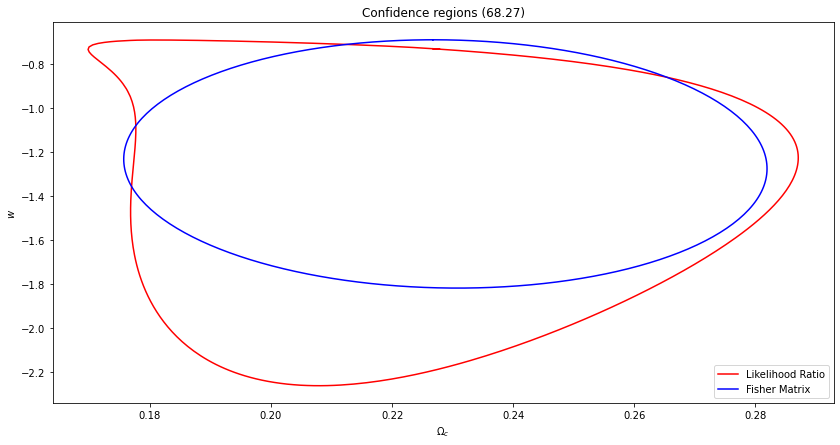

In [14]:
plt.figure (figsize=(14, 7))
plt.title ("Confidence regions (%.2f)" % (cr_rg.clevel * 100.0))
plt.plot (cr_p1array, cr_p2array, 'r', label="Likelihood Ratio")
plt.plot (fisher_p1array, fisher_p2array, 'b-', label="Fisher Matrix")

plt.xlabel(r'$\Omega_c$')
plt.ylabel(r'$w$')

plt.legend(loc=4)

plt.savefig ("snia_bao_rg_omegac_w.svg")